In [1]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from tqdm.auto import tqdm

from sklearn.neighbors import NearestNeighbors
import ast

import seaborn as sns
from catboost import CatBoostRegressor, Pool

In [2]:
data_folder = "./dataset_additional/"

users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

data_folder = "./"

train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"movie_id": list}).reset_index()

In [3]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

In [4]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

# KNN

Посмотрим, как себя покажем классический KNN. Поскольку пользователей в датасете достаточно много, построить KNN на основе данных о всех пользователях было бы очень времязатратно. Поэтому построим модель на айтемах, которых на порядок меньше. Первая идея такая: для каждого пользователя из тестовых данных найдём топ-10 фильмов, расстояние до "усредненных" просмотренных пользователем фильмов которых минимально.

In [5]:
items_df.head(2)

,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
0,0,"Мама, я дома",2022-01-01,2022-11-23T00:00:00,Где-то в глубинке вместе с дочерью и внуком жи...,[97],[238],"[1883, 33655, 25890, 1001, 12051, 10110, 16895]",NaN,NaN,NaN
1,1,Три метра над уровнем неба,2010-01-01,NaN,"История любви парня и девушки, принадлежащих к...","[138, 97, 294]",[242],"[18168, 23444, 10850, 21847, 30555, 24469, 268...",Tres metros sobre el cielo,16.0,"Три, метра, над, уровнем, неба, 2010, Испания,..."


Определимся, с какими признаками будем работать. Во-первых, логично сравнивать фильмы по жанру, стране и актерам/режиссёрам, т.к. это наиболее весомые признаки. Остальные признаки использовать не будем, т.к. они либо  не имеют отношения к схожести фильмов, либо коррелируют с выбранными признаками (например, year и staff). 

Приведём столбцы, с которыми будем работать, к спискам целых чисел.

In [6]:
items_df['genres'] = [ast.literal_eval(genres) for genres in items_df['genres']]
items_df['countries'] = [ast.literal_eval(countries) for countries in items_df['countries']]
items_df['staff'] = [ast.literal_eval(staff) for staff in items_df['staff']]

In [7]:
class KNN(BaseRecommender):
    def __init__(self):
        super().__init__()
        self.mlb = MultiLabelBinarizer()
        self.binarized_df = pd.DataFrame()
        
    def _add_bin_column(self, column):
        # применяем one-hot кодирование
        binarized_column = pd.DataFrame(self.mlb.fit_transform(items_df[column]))
        
        # чтобы признаков в итоге получилось не слишком много, выберем наиболее попурярные
        sums = binarized_column.sum()
        top_100_columns = sums.nlargest(100).index
        binarized_column = binarized_column[top_100_columns]
        
        # дадим признакам веса в зависимости от того, насколько они популярны
        max_sum = binarized_column.sum().max()
        binarized_column = binarized_column.apply(lambda col: col * (col.sum() / max_sum) if max_sum != 0 else 0)
        
        self.binarized_df = pd.concat([self.binarized_df, pd.DataFrame(binarized_column)], axis=1)
        
    def _get_best(self, inds, n_neighbors=10):
        if len(inds) == 0:
            return []
        
        sum_row = self.binarized_df.loc[inds].sum()

        distances, indices = self.knn_model.kneighbors([sum_row], n_neighbors=n_neighbors+len(inds))

        answer = [index for index in indices[0] if index not in inds]
        return answer[:n_neighbors]
        

    def fit(self, df: pd.DataFrame, train_df: pd.DataFrame, item_id_cols: list[int]) -> None:
        for column in item_id_cols:
            self._add_bin_column(column)
            
        self.binarized_df.columns = self.binarized_df.columns.astype(str)
            
        self.train_df = train_df.groupby("user_id").agg({"movie_id": list}).reset_index()
        self.train_df['movie_id'] = self.train_df['movie_id'].apply(lambda x: np.array([int(i) for i in x]))
        
        self.knn_model = NearestNeighbors()
        self.knn_model.fit(self.binarized_df.values)
            
        self.trained = True
        

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        assert self.trained

        return [self._get_best(list(list(self.train_df[self.train_df['user_id'] == id]['movie_id'])[0])) 
                for id in df['user_id']]

In [8]:
knn = KNN()
knn.fit(items_df, train_part, ['genres', 'countries', 'staff'])

In [9]:
%%time
test_part['knn_recs'] = knn.predict(test_part)

CPU times: total: 9min 18s
Wall time: 10min 6s


In [10]:
evaluate_recommender(df=test_part, model_preds_col="knn_recs")

{'ndcg': 0.022481548834698276, 'recall': 0.010370621777172335}

Значения метрик практически нулевые. Вероятно, это связано с тем, что мы используем мало признаков, а также практически не учитываем популярность фильмов, хотя, как мы поняли, это очень важный признак. 

# Градиентный бустинг

In [11]:
class GradientBoosting(BaseRecommender):
    def __init__(self, iterations: int = 1, learning_rate: float = 0.25, depth: int = 6):
        super().__init__()
        self.mlb = MultiLabelBinarizer()
        self.model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=False)

        
        
        # Бинарные признаки закодируем как 0 и 1, а остальные признаки являются порядковыми, 
        # поэтому можно их просто равномерно нормировать


        self._age_encoder = {
            '18-24': 0.0,
            '25-34': 0.2,
            '35-44': 0.45,
            '45-54': 0.69,
            '55-70': 1.0
        }

        self._income_encoder = {
            'низкий': 0.0,
            'средний': 0.33,
            'высокий': 0.67,
            'очень высокий': 1.0
        }
        
        self._sex_encoder = {
            'Женский': 0.0,
            'Мужской': 1.0
        }
        
        self._education_encoder = {
            'Без образования': 0.0,
            'Среднее': 0.33,
            'Неполное высшее': 0.67,
            'Высшее': 1.0
        }
        
        
    # Закодируем категориальные признаки в соответсвтии со словарями, None заменим средними значениями
    def _prepare_categorical_features(self) -> None:
        self.df['age_category'] = self.df['age_category'].replace(self._age_encoder)
        self.df['age_category'].fillna(self.df['age_category'].mean(), inplace=True)

        self.df['income'] = self.df['income'].replace(self._income_encoder)
        self.df['income'].fillna(self.df['income'].mean(), inplace=True)
        
        self.df['sex'] = self.df['sex'].replace(self._sex_encoder)
        self.df['sex'].fillna(self.df['sex'].mean(), inplace=True)
        
        self.df['education'] = self.df['education'].replace(self._education_encoder)
        self.df['education'].fillna(self.df['education'].mean(), inplace=True)
        
        self.df['kids_flg'].fillna(self.df['kids_flg'].mean(), inplace=True)
        
    def _prepare_movies(self) -> None:
        # Для каждого пользователя оставим только информацию о самых популярных фильмах
        self.df['movie_id'] = [[movie for movie in movies if movie in self.recommendations] for movies in self.df['movie_id']]
        
        # Применим one-hot кодирование
        binarized_column = self.mlb.fit_transform(self.df['movie_id'])
        binarized_column_df = pd.DataFrame(binarized_column, columns=self.mlb.classes_)

        self.df = pd.concat([self.df, pd.DataFrame(binarized_column_df)], axis=1)

        self.df.drop(columns=['movie_id'], inplace=True)
        
        
    def _prepare(self) -> None:
        self._prepare_categorical_features()
        self._prepare_movies()

    def fit(self, train_df: pd.DataFrame, items_df: pd.DataFrame) -> None:
        self.recommendations = set(train_df['movie_id'].value_counts().index.values[:100])
        
        self.df = train_df.groupby("user_id").agg({"movie_id": list}).reset_index()
        self.df = pd.merge(self.df, users_df, on='user_id', how='left')
        
        self.grouped_df = train_df.groupby("user_id").agg({"movie_id": list}).reset_index()
        
        self.matrix = pd.DataFrame(self.mlb.fit_transform(self.df['movie_id']), columns=self.mlb.classes_)
        
        self._prepare()
        self.trained = True
        
    def _predict(self, ind) -> None: # Функция предсказания для пользователей с номерами от ind до ind+test_rows
        current_test_df = self.test_df.iloc[ind: min(ind + self.test_rows, len(self.test_df))]
        
        # Разделим данные на одучающую и тестовую части
        mask = self.df['user_id'].isin(current_test_df['user_id'])
        
        train_indices = self.df.index[~mask]
        test_indices = self.df.index[mask]

        X_train = self.df.iloc[train_indices]
        X_test = self.df.iloc[test_indices]
        
        for movie in self.matrix.columns: # Для каждого фильма обучим модель и сделаем предсказание
            target_matrix = self.matrix[[movie]]
            
            y_train = target_matrix.iloc[train_indices]
            
            # Если ни один пользователь из обучающей части не посмотрел фильм, то обучать модель нет смысла
            if len(y_train.iloc[:, 0].unique()) == 1: 
                self.ratings.loc[ind:min(ind + self.test_rows, len(self.test_df)), y_train.columns] = 0
                continue
                
            # Если фильм популярный, то он присутствует как признак. 
            # В таком случае его нужно удалить, чтобы корректно обучить модель
            if movie in self.recommendations:
                train_pool = Pool(data=X_train.drop(columns=[movie]), label=y_train)
                test_pool = Pool(data=X_test.drop(columns=[movie]))
            else:
                train_pool = Pool(data=X_train, label=y_train)
                test_pool = Pool(data=X_test)                

            self.model.fit(train_pool)

            predictions = self.model.predict(test_pool)
            
            # Запишем предсказания в датафрейм ratings. Чем выше ratings[user_id][movie], 
            # тем вероятнее пользователь user_id посмотрит фильм movie
            self.ratings.loc[ind:min(ind + self.test_rows, len(self.test_df)) - 1, y_train.columns] = predictions.reshape(-1, 1)

    def predict(self, df: pd.DataFrame, test_parts: int = 1) -> list:
        '''
        test_parts в данном методе - это количество частей, на которые мы будем делить тестовую часть. 
        Т.е. если test_parts == len(test_part), то для каждого пользователя из тестовой части будем отдельно обучать 
        модель, используя для обучения всех пользователей кроме текущего. Если test_parts == 1, 
        то модель будем обучать только один раз - на всех пользователях кроме тестовых.
        '''

        assert self.trained

        self.test_df = df
        self.test_rows = len(df) // test_parts
        
        # Создаем матрицу, в которой для каждой пары (user_id, movie) будет записано предсказание.
        self.ratings = pd.DataFrame(columns=self.matrix.columns, index=range(len(self.test_df)))
        
        # Делаем предсказания по частям
        for ind in range (0, len(self.test_df), self.test_rows):
            self._predict(ind)
        
        # Если пользователь user_id посмотрел фильм movie, то считаем, что ratings[user_id][movie] = 0,
        # чтобы не рекомендовать фильм, который пользователь уже посмотрел.
        for user in range(len(self.test_df)):
            user_id = self.test_df.iloc[user]['user_id']
            self.ratings.iloc[user][list(self.grouped_df[self.grouped_df['user_id'] == user_id]['movie_id'])[0]] = 0
            
        # Выбираем для каждого пользователя 10 фильмов с наивысшей оценкой.
        self.ratings = self.ratings.astype(float)
        top_10_movies = self.ratings.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)

        return top_10_movies.tolist()

In [12]:
model = GradientBoosting(iterations = 5, learning_rate = 0.25, depth = 6)
model.fit(train_part, items_df)

In [13]:
%%time
test_part['gb_recs'] = model.predict(test_part, 1)

CPU times: total: 30min 58s
Wall time: 35min 12s


In [14]:
evaluate_recommender(df=test_part, model_preds_col="gb_recs")

{'ndcg': 0.16265449655855577, 'recall': 0.08641699018406641}

Модель показывает результат чуть лучше, чем если бы мы рекомендовали всем пользователям самые популярные фильмы. В отличие от предыдущей модели градиентный бустинг неявно учитывает популярность фильмов, ведь чем популярнее фильм, тем больше различных пользователей его посмотрело, а значит, в решающем дереве на него наложено меньше "ограничений". Также эта модель использует информацию о пользователях и обучается для каждого фильма отдельно. Кроме того, метрики вероятно можно улучшить, если оптимально подобрать гиперпараметры.

Теперь проанализируем предсказания моделей. Оценим, насколько точно модели повторяют распределение для 10 случайных фильмов.

In [15]:
movies = np.random.choice(train_part['movie_id'].value_counts().index.values[:500], size=10, replace=False)

In [16]:
value_counts = train_part['movie_id'].value_counts()
counts = value_counts[movies]

In [17]:
movies_gb = pd.DataFrame(np.concatenate(test_part['gb_recs'].tolist()))
counts_gb = movies_gb[0].value_counts()
counts_gb = counts_gb.reindex(movies, fill_value=0)
counts_gb = counts_gb[movies]

In [18]:
movies_knn = pd.DataFrame(np.concatenate(test_part['knn_recs'].tolist()))
counts_knn = movies_knn[0].value_counts()
counts_knn = counts_knn.reindex(movies, fill_value=0)
counts_knn = counts_knn[movies]

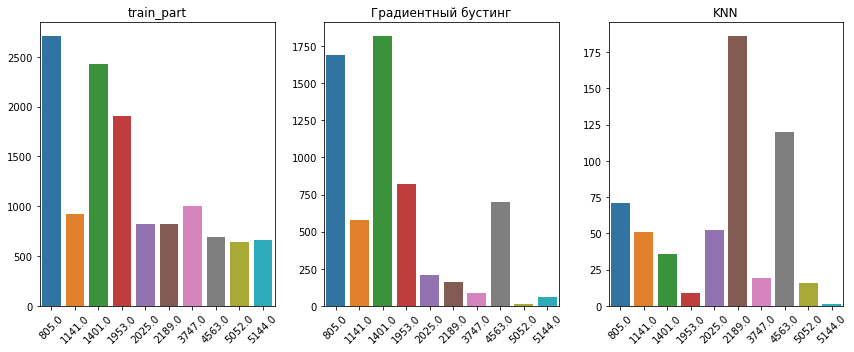

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('train_part')

sns.barplot(x=counts_gb.index, y=counts_gb.values, ax=axes[1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_title('Градиентный бустинг')

sns.barplot(x=counts_knn.index, y=counts_knn.values, ax=axes[2])
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_title('KNN')

plt.tight_layout()
plt.show()


По графикам видно, что градиентный бустинг более точно повторяет распределение фильмов, чем KNN. 